In [10]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.utils import softmax

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
import sys
sys.path.append(os.path.join(os.path.abspath(''), '..'))
from utils.graph import grid_to_graph, graph_to_grid

In [6]:
class GraphDataset(Dataset):
    def __init__(self, root):
        super(GraphDataset, self).__init__(root)
        self.root = root
        self.file_names = os.listdir(root)

    def len(self):
        return len(self.file_names)

    def get(self, idx):
        return torch.load(os.path.join(self.root, self.file_names[idx]))

In [7]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = SAGEConv(13, 32, aggr='add')
        self.conv2 = SAGEConv(32, 64, aggr='add')
        self.conv3 = SAGEConv(64, 128, aggr='add')
        self.lin1 = torch.nn.Linear(13 + 128, 64)
        self.lin2 = torch.nn.Linear(64, 32)
        self.lin3 = torch.nn.Linear(32, 1)

    def forward(self, data):
        x, edge_index, mask, batch = data.x, data.edge_index, data.mask, data.batch
        x_global = global_mean_pool(x, batch)

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        

        x_combined = torch.cat([x, x_global[batch]], dim=1)
        x_combined = F.relu(self.lin1(x_combined))
        x_combined = F.relu(self.lin2(x_combined))
        logits = self.lin3(x_combined)
        
        masked_logits = logits.clone()
        masked_logits[~mask] = -1e12

        return softmax(masked_logits, batch)

In [9]:
dataset = GraphDataset('../data/processed/')
loader = DataLoader(dataset, batch_size=1000, shuffle=True)

model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = 'cpu' # torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

epochs = 1
for epoch in range(epochs):
    for i, data in enumerate(loader):
        data = data.to(device)
        optimizer.zero_grad()

        # laplace smoothing
        output = model(data).unsqueeze(0)
        output = (output + 1e-12) / (output.sum() + 1e-12)
        target = data.y.unsqueeze(0)
        target = (target + 1e-12) / (target.sum() + 1e-12)
        
        loss = F.kl_div(output.log(), target, reduction='batchmean')
        loss.backward()
        optimizer.step()
        print(f'Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}')

Epoch: 0, Batch: 0, Loss: 3.0435550212860107
Epoch: 0, Batch: 1, Loss: 3.017017126083374
Epoch: 0, Batch: 2, Loss: 2.9286787509918213
Epoch: 0, Batch: 3, Loss: 2.9000632762908936
Epoch: 0, Batch: 4, Loss: 2.8651115894317627
Epoch: 0, Batch: 5, Loss: 2.8270015716552734
Epoch: 0, Batch: 6, Loss: 2.7459089756011963
Epoch: 0, Batch: 7, Loss: 2.725433111190796
Epoch: 0, Batch: 8, Loss: 2.642876148223877
Epoch: 0, Batch: 9, Loss: 2.6115424633026123
Epoch: 0, Batch: 10, Loss: 2.5883028507232666
Epoch: 0, Batch: 11, Loss: 2.5482571125030518
Epoch: 0, Batch: 12, Loss: 2.5148205757141113
Epoch: 0, Batch: 13, Loss: 2.5039029121398926
Epoch: 0, Batch: 14, Loss: 2.4722182750701904
Epoch: 0, Batch: 15, Loss: 2.464484691619873
Epoch: 0, Batch: 16, Loss: 2.4763011932373047
Epoch: 0, Batch: 17, Loss: 2.435534954071045
Epoch: 0, Batch: 18, Loss: 2.411219596862793
Epoch: 0, Batch: 19, Loss: 2.401928186416626
Epoch: 0, Batch: 20, Loss: 2.408071756362915
Epoch: 0, Batch: 21, Loss: 2.3611433506011963
Epoch:

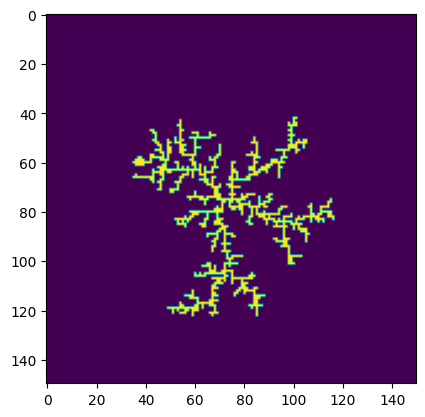

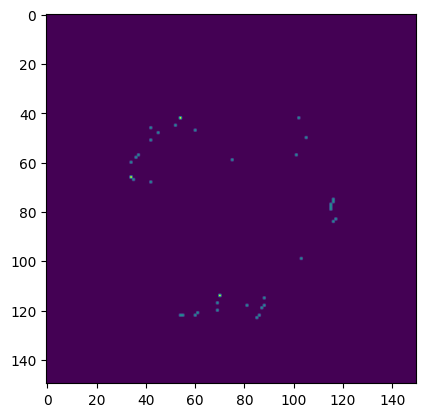

In [ ]:
grid_df = pd.read_parquet('../data/0b362cee-93de-4351-a234-a3513a304d1c_grid.parquet')
grid = grid_df.iloc[-1].to_numpy().reshape(150, 150)
distribution_df = pd.read_parquet('../data/0b362cee-93de-4351-a234-a3513a304d1c_distribution.parquet')
distribution = distribution_df.iloc[-1].to_numpy().reshape(150, 150)

plt.imshow(grid)
plt.show()
plt.imshow(distribution);

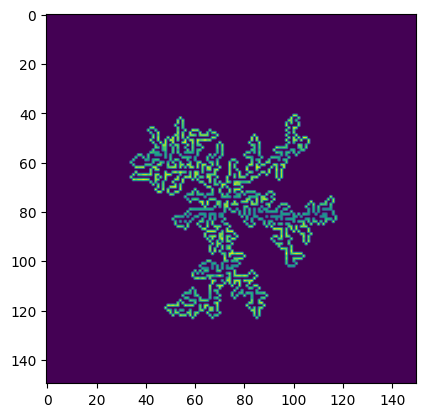

In [ ]:
node_positions, edges, mask, input_nodes, target_nodes = grid_to_graph(grid, distribution)
node_positions = torch.tensor(node_positions, dtype=torch.long)
edges = torch.tensor(edges, dtype=torch.long).t().contiguous()
mask = torch.tensor(mask, dtype=torch.bool)
input_nodes = torch.tensor(input_nodes, dtype=torch.float)
target_nodes = torch.tensor(target_nodes, dtype=torch.long)
batch = torch.zeros(len(input_nodes), dtype=torch.long)

data = Data(x=input_nodes, edge_index=edges, y=target_nodes, pos=node_positions, mask=mask, batch=batch)
data.to(device)

model.to(device)
model.eval()
with torch.no_grad():
    output_nodes = model(data).cpu().detach().numpy()
    node_positions = node_positions.cpu().detach().numpy()
    plt.imshow(graph_to_grid(node_positions, output_nodes))

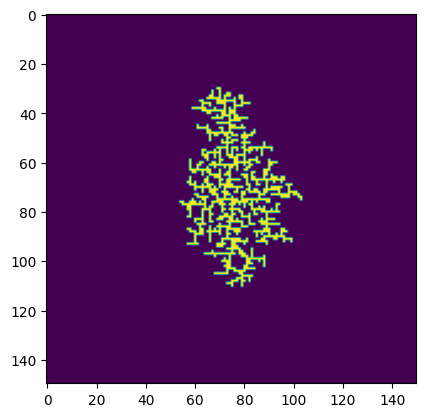

In [18]:
n = 150
grid = np.zeros((n, n))
grid[n//2, n//2] = 1

for _ in range(1000):
    node_positions, edges, mask, input_nodes, _ = grid_to_graph(grid)
    node_positions = torch.tensor(node_positions, dtype=torch.long)
    edges = torch.tensor(edges, dtype=torch.long).t().contiguous()
    mask = torch.tensor(mask, dtype=torch.bool)
    input_nodes = torch.tensor(input_nodes, dtype=torch.float)
    batch = torch.zeros(len(input_nodes), dtype=torch.long)

    data = Data(x=input_nodes, edge_index=edges, pos=node_positions, mask=mask, batch=batch)
    data.to(device)

    output_nodes = model(data).cpu().detach().numpy()
    node_positions = node_positions.cpu().detach().numpy()

    output = graph_to_grid(node_positions, output_nodes)
    output = output / output.sum()

    idx = np.random.choice(n*n, p=output.flatten())
    grid[idx // n, idx % n] = 1

plt.imshow(grid)
plt.show()